In [232]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, VotingClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB

In [2]:
# Read in the data: 

df = pd.read_csv('../data/toddlers_and_parents.csv',lineterminator='\n')
df.head()

,subreddit,title,selftext,created_utc,author,post_length,post_word_count
0,1,3-year-old with constant nightmares,looking advice help never good sleeper less ha...,1664511751,lauraliegrace,1295,240
1,1,How did you organize sleep hours once your tod...,prek many hours sleep per night much nap start...,1664506846,mamaleti,875,170
2,1,2 yrs toddler’s repetitive movements. concerns ?,think overthinking sure boy perfectly normal f...,1664506140,ptkhisti,917,173
3,1,"Sometimes I lose my cool, how badly will this ...",husband sometimes snap often twice week practi...,1664503385,ughidcwhatitis,1128,222
4,1,"""momma can I have a bowl of popcorn, warm milk...",yes yes yes yes sweet thankful wonderful ideas...,1664503064,eighteightfivesix,157,31


In [3]:
df.shape

(4734, 7)

In [4]:
df.isnull().sum()

subreddit          0
title              0
selftext           0
created_utc        0
author             0
post_length        0
post_word_count    0
dtype: int64

In [5]:
# Baseline accuracy:

df['subreddit'].value_counts(normalize = True)

1    0.520068
0    0.479932
Name: subreddit, dtype: float64

In [6]:
# meaning that 52% of the time we'd be correct if we said that the post comes from toddlers subreddit
# For this project the metric that will be looked at is the f1 score, since it is difficult to compare two models 
# with low precision and high recall or vice versa. So to make them comparable, we use f1 score.
# (https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62)

In [8]:
X = df['selftext']
y = df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify=y)

---

In [165]:
# Create the function to fit, evaluate and plot confusion matrix:
# Idea taken from (https://www.dataknowsall.com/classification.html)

def fit_and_print(gs, pipe_name):
    #gs = GridSearchCV(pipe, param_grid=pipe_params, n_jobs= -1, verbose=1, cv = 3)
    gs.fit(X_train, y_train)
    preds = gs.predict(X_test)
    
    # Calculate the scores: 
    y_pred = gs.predict_proba(X_test)[:,1]
    best_score = gs.best_score_
    train_score = gs.score(X_train, y_train)
    test_score = gs.score(X_test, y_test)
    f1 = f1_score(y_test, preds, average='weighted')
    
    # Save these numbers in a list and put them into a dataframe: 
    model_list = [pipe_name, best_score, train_score, test_score, f1] 
    models = pd.DataFrame(model_list, index = ['pipe_name', 'best_score', 'train_score', 'test_score', 'f1_score']).T
    
    # Display the confusion matrix:
    cm = confusion_matrix(y_test, preds)
    ConfusionMatrixDisplay(cm).plot(cmap = 'YlOrRd', values_format = 'd');
    
    return models

In [166]:
# Logistic Regression:

cvec_lr = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression(max_iter = 5000))
])

pipe_params = {
    'cvec__max_features': [2000,3000],
    'cvec__min_df': [2,4],
    'cvec__max_df': [1.0, 0.5],
    'lr__solver': ['saga'],
    'lr__penalty':['l1', 'l2', 'none']
}

gs_1 = GridSearchCV(cvec_lr,
                 param_grid = pipe_params,
                 n_jobs = -1)

,pipe_name,best_score,train_score,test_score,f1_score
0,cvec_lr,0.667324,0.947042,0.654561,0.653232


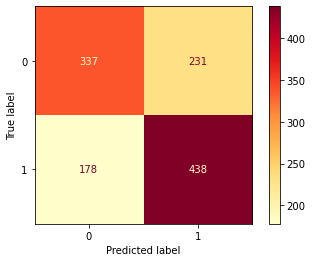

In [167]:
df1 = fit_and_print(gs_1, 'cvec_lr')
df1

In [168]:
tf_lr = Pipeline([
    ('tf', TfidfVectorizer()),
    ('lr', LogisticRegression(max_iter = 5000))
])

pipe_params_2 = {
    'tf__max_features': [2000,3000],
    'tf__min_df': [2,4],
    'tf__max_df': [1.0, 0.5],
    'lr__solver': ['saga'],
    'lr__penalty':['l1', 'l2', 'none']
}

gs_2 = GridSearchCV(tf_lr,
                      param_grid = pipe_params_2,
                      n_jobs = -1)

,pipe_name,best_score,train_score,test_score,f1_score
0,tf_lr,0.711268,0.850704,0.6875,0.685966


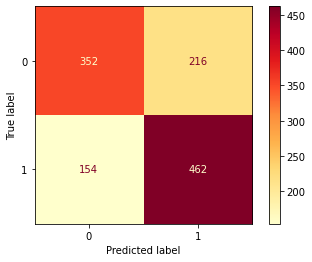

In [169]:
df2 = fit_and_print(gs_2, 'tf_lr')
df2

In [170]:
pd.concat([df1, df2])

,pipe_name,best_score,train_score,test_score,f1_score
0,cvec_lr,0.667324,0.947042,0.654561,0.653232
0,tf_lr,0.711268,0.850704,0.6875,0.685966


In [23]:
# The confusion matrices represent that the model doesnt work very well. We have more than 200 false negative and 178(154) false negative results. A lot of misclassification. 
# The linear regression model is overfit as you can see from the test and train result. 
# On the other hand, f1 score is not that bad, so after tuning some hyperparameters, we're going to move on to the next model...

---

In [171]:
# Random Forest:

cvec_rf = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier())
    ])

rf_params = {
    'cvec__max_features': [2000,3000],
    'cvec__min_df': [2,4],
    'cvec__max_df': [1.0, 0.5],
    'rf__n_estimators': [100,200],
    'rf__max_depth': [None, 1,2,3,4]
}

gs_3 = GridSearchCV(cvec_rf, param_grid = rf_params, cv = 5)

,pipe_name,best_score,train_score,test_score,f1_score
0,cvec_rf,0.678592,0.997183,0.675676,0.675805


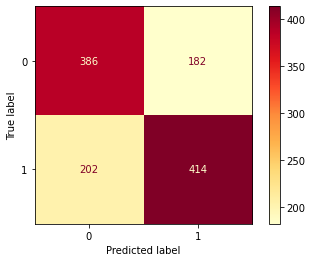

In [172]:
df3 = fit_and_print(gs_3, 'cvec_rf')
df3

In [173]:
tf_rf = Pipeline([
    ('tf', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
    ])

rf_params_2 = {
    'tf__max_features': [2000,3000],
    'tf__min_df': [2,4],
    'tf__max_df': [1.0, 0.5],
    'rf__n_estimators': [100,200],
    'rf__max_depth': [None, 1,2,3,4] 
}

gs_4 = GridSearchCV(tf_rf, param_grid = rf_params_2, cv = 5)

,pipe_name,best_score,train_score,test_score,f1_score
0,tf_rf,0.687887,0.997183,0.689189,0.689274


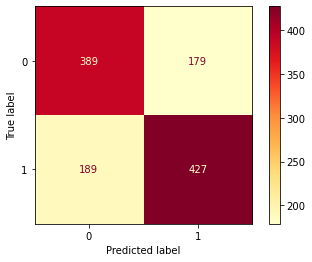

In [174]:
df4 = fit_and_print(gs_4, 'tf_rf')
df4

In [175]:
pd.concat([df3, df4])

,pipe_name,best_score,train_score,test_score,f1_score
0,cvec_rf,0.678592,0.997183,0.675676,0.675805
0,tf_rf,0.687887,0.997183,0.689189,0.689274


In [176]:
# From the table above we can see that the models are overfit again, even though the f1 scores are better. 
# The confusion Matrix looks very similar to the previous model. 

---

In [177]:
# Decision Tree:

cvec_dt = Pipeline([
        ('cvec', CountVectorizer()),
        ('dt', DecisionTreeClassifier(random_state=42))
        ])

dt_params = {
    'cvec__max_features': [3000, 4000],
    'cvec__min_df': [2,4],
    'cvec__max_df': [1.0, 0.5],
    'dt__min_samples_split': [15,20],
    'dt__min_samples_leaf': [10,15],
    'dt__max_depth':[3]
}
gs_5 = GridSearchCV(cvec_dt, param_grid = dt_params, cv = 5)

,pipe_name,best_score,train_score,test_score,f1_score
0,cvec_dt,0.589859,0.604507,0.591216,0.540877


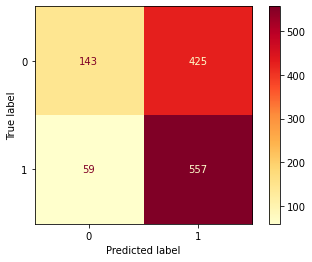

In [178]:
df5 = fit_and_print(gs_5, 'cvec_dt')
df5

In [179]:
tf_dt = Pipeline([
        ('tf', TfidfVectorizer()),
        ('dt', DecisionTreeClassifier(random_state=42))
        ])

dt_params = {
    'tf__max_features': [2000,3000],
    'tf__min_df': [2,4],
    'tf__max_df': [1.0, 0.5],
    'dt__min_samples_split': [15,20,25],
    'dt__min_samples_leaf': [15, 25],
    'dt__max_depth':[3]
}
gs_6 = GridSearchCV(tf_dt, param_grid = dt_params, cv = 5)

,pipe_name,best_score,train_score,test_score,f1_score
0,tf_dt,0.590423,0.604507,0.591216,0.540877


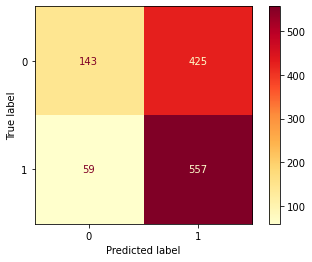

In [180]:
df6 = fit_and_print(gs_6, 'tf_dt')
df6

In [181]:
pd.concat([df5, df6])

,pipe_name,best_score,train_score,test_score,f1_score
0,cvec_dt,0.589859,0.604507,0.591216,0.540877
0,tf_dt,0.590423,0.604507,0.591216,0.540877


In [ ]:
# This model performed best so far, it's not overfit, although its f1 score is not the highest/
# The confusion Matrix looks much better, less amount of false positives, less misclassification. We want to minimize the FN bacause we want to target as many parents with toddlers as possible. 

---

In [182]:
# AdaBoost with Logistic Regression Estimator:

cvec_ada = Pipeline([
    ('cvec', CountVectorizer()),
    ('ada', AdaBoostClassifier(base_estimator=LogisticRegression(), random_state=42))
])
ada_lr_params = {
    'cvec__max_features': [2000,3000],
    'cvec__min_df': [2,4],
    'ada__n_estimators': [50,100],
    'ada__base_estimator__C': [0.1, 1.0],
    'ada__learning_rate': [0.9, 1.0]
}
gs_7= GridSearchCV(cvec_ada, param_grid = ada_lr_params, cv = 3)

,pipe_name,best_score,train_score,test_score,f1_score
0,cvec_ada,0.686476,0.828732,0.679054,0.676484


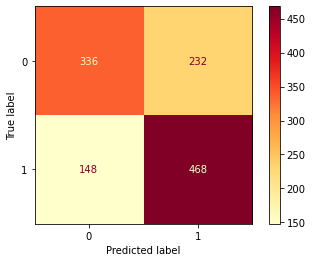

In [183]:
df7 = fit_and_print(gs_7, 'cvec_ada')
df7

In [184]:
tf_ada = Pipeline([
    ('tf', TfidfVectorizer()),
    ('ada', AdaBoostClassifier(base_estimator=LogisticRegression(), random_state=42))
])

ada_lr_params_2 = {
    'tf__max_features': [2000,3000],
    'tf__min_df': [2,4],
    'tf__max_df': [1.0, 0.5],
    'ada__n_estimators': [50,100],
    'ada__base_estimator__C': [0.1, 1.0],
}
gs_8= GridSearchCV(tf_ada, param_grid = ada_lr_params_2, cv = 3)

,pipe_name,best_score,train_score,test_score,f1_score
0,tf_ada,0.658591,0.689859,0.655405,0.626935


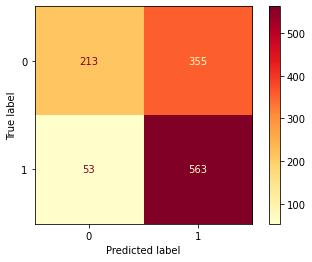

In [185]:
df8 = fit_and_print(gs_8, 'tf_ada')
df8

In [186]:
pd.concat([df7, df8])

,pipe_name,best_score,train_score,test_score,f1_score
0,cvec_ada,0.686476,0.828732,0.679054,0.676484
0,tf_ada,0.658591,0.689859,0.655405,0.626935


In [187]:
# The AdaBoost with Tfid vecoriser is not overfit and the f1 score is not much lower than the previous models. we will definitely keep an eye on this one.
# The first misclassification matrix is showing how poorly the classification modelworked with so many false negatives and false positives. 

---

In [188]:
# KNN:
cvec_knn = Pipeline([
    ('cvec', CountVectorizer()),
    ('ss', StandardScaler(with_mean=False)),
    ('knn', KNeighborsClassifier())
])

pipe_params_knn = {
    'cvec__max_features': [2000,3000],
    'cvec__min_df': [2,4],
    'cvec__max_df': [1.0, 0.5],
    'knn__n_neighbors':[3, 5]
}
gs_10 = GridSearchCV(cvec_knn,
                      param_grid = pipe_params_knn,
                      n_jobs = -1)

,pipe_name,best_score,train_score,test_score,f1_score
0,cvec_knn,0.558592,0.772394,0.550676,0.531442


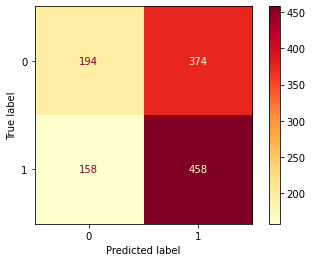

In [189]:
df10 = fit_and_print(gs_10, 'cvec_knn')
df10

In [190]:
tf_knn = Pipeline([
    ('tf', TfidfVectorizer()),
    ('ss', StandardScaler(with_mean=False)),
    ('knn', KNeighborsClassifier())
])

pipe_params_knn = {
    'tf__max_features': [2000,3000],
    'tf__min_df': [2,4],
    'tf__max_df': [1.0, 0.5],
    'knn__n_neighbors':[3, 5]
}

gs_9 = GridSearchCV(tf_knn,
                      param_grid = pipe_params_knn,
                      n_jobs = -1)

,pipe_name,best_score,train_score,test_score,f1_score
0,tf_knn,0.548169,0.699718,0.554899,0.481325


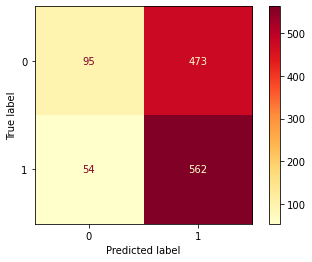

In [191]:
df9 = fit_and_print(gs_9, 'tf_knn')
df9

In [192]:
pd.concat([df9, df10])

,pipe_name,best_score,train_score,test_score,f1_score
0,tf_knn,0.548169,0.699718,0.554899,0.481325
0,cvec_knn,0.558592,0.772394,0.550676,0.531442


In [193]:
# KNN model is not really designed for this type of project as it is struggles with multidimentionelity, so we won't come back to it. 

---

In [194]:
# Multinomial Naive Bayes

cvec_nb = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])
pipe_params_nb = {
    #'cvec__max_features': [2000,3000],
    'cvec__min_df': [2,4],
    'cvec__max_df': [1.0, 0.5],
    'nb__alpha': [0.1, 0.2, 0.3],#,0.25,0.5,0.8,1],
    'nb__class_prior': [None, [.1,.9],[.2, .8]]
}
gs_11 = GridSearchCV(cvec_nb,
                      param_grid = pipe_params_nb,
                      n_jobs = -1)

,pipe_name,best_score,train_score,test_score,f1_score
0,cvec_nb,0.718873,0.857746,0.701014,0.696234


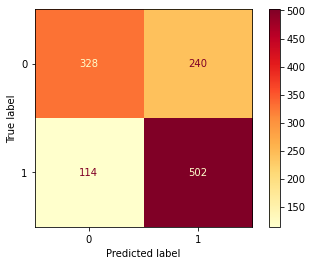

In [195]:
df11 = fit_and_print(gs_11, 'cvec_nb')
df11

In [196]:
tf_nb = Pipeline([
    ('tf', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

pipe_params_nb_2 = {
    'tf__max_features': [3000, 4000],
    'tf__min_df': [2,4],
    'tf__max_df': [1.0, 0.5],
    'nb__alpha': [0.1, 0.2, 0.3],
    'nb__class_prior': [None, [.1,.9],[.2, .8]]
}
gs_12 = GridSearchCV(tf_nb,
                      param_grid = pipe_params_nb_2,
                      n_jobs = -1)

,pipe_name,best_score,train_score,test_score,f1_score
0,tf_nb,0.706197,0.819718,0.697635,0.69698


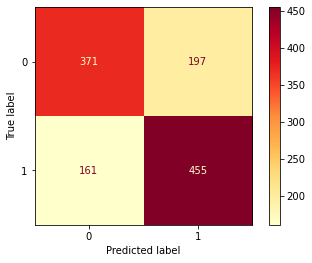

In [197]:
df12 = fit_and_print(gs_12, 'tf_nb')
df12

In [198]:
pd.concat([df11, df12])

,pipe_name,best_score,train_score,test_score,f1_score
0,cvec_nb,0.718873,0.857746,0.701014,0.696234
0,tf_nb,0.706197,0.819718,0.697635,0.69698


In [199]:
# Again, we see here the overfit models with so far highest f1 scores. 
# Although you acn see that the false negatives here are similarly represented by the CM. 

---

In [200]:
# Let's quickly check if Bagging classifier is doing any better: 
bag_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('bag', BaggingClassifier(random_state=42))
])

# Fit BaggingClassifier.
bag_pipe.fit(X_train, y_train)

# Score BaggingClassifier
print(bag_pipe.score(X_train, y_train))
print(bag_pipe.score(X_test, y_test))

0.9828169014084507
0.6342905405405406


In [201]:
# Turns out it's not performing any better...

---

In [202]:
# Combine all scores from the models: 

big_one = pd.concat([df1,df2, df3,df4,df5,df6,df7,df8,df9,df10,df11,df12])
big_one

,pipe_name,best_score,train_score,test_score,f1_score
0,cvec_lr,0.667324,0.947042,0.654561,0.653232
0,tf_lr,0.711268,0.850704,0.6875,0.685966
0,cvec_rf,0.678592,0.997183,0.675676,0.675805
0,tf_rf,0.687887,0.997183,0.689189,0.689274
0,cvec_dt,0.589859,0.604507,0.591216,0.540877
0,tf_dt,0.590423,0.604507,0.591216,0.540877
0,cvec_ada,0.686476,0.828732,0.679054,0.676484
0,tf_ada,0.658591,0.689859,0.655405,0.626935
0,tf_knn,0.548169,0.699718,0.554899,0.481325
0,cvec_knn,0.558592,0.772394,0.550676,0.531442


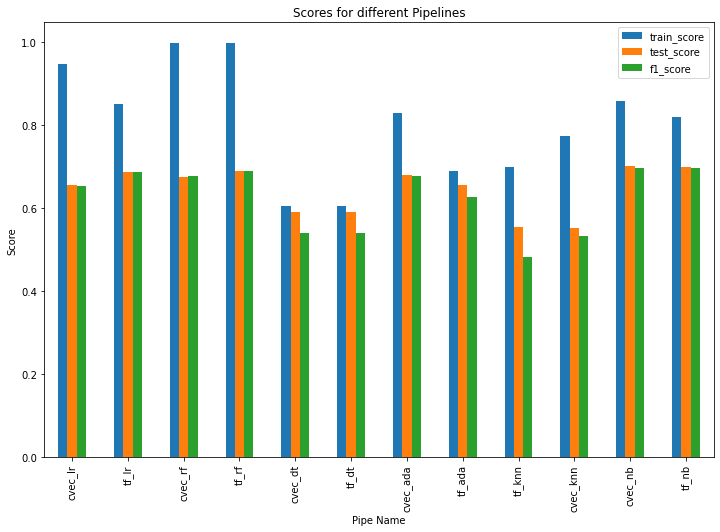

In [228]:
big_one.plot(x='pipe_name', y = ['train_score', 'test_score', 'f1_score'], kind = 'bar', figsize=(12,8),xlabel = "Pipe Name", ylabel = 'Score', title = 'Scores for different Pipelines');
plt.savefig("../images/Scores for different Pipelines.jpg");

In [ ]:
# From the graph above we can see that the least overfit model is Desicion Tree and the highest f1 score model is the MultinomialNB. 
# Ada classifier also performed well and had higher than DT f1 score. So we will focus on these when stacking them together

---

In [ ]:
# Now we're going to take out best performing models (Ada booster and Decision Tree) and stack them together:
# (in the same manner as we did in calss)

In [242]:
level1_estimators  = [
    ('ada_pipe', Pipeline([
        ('tf', TfidfVectorizer()),
        ('ada', AdaBoostClassifier(learning_rate=0.7, n_estimators=300, random_state=42))
    ])),
    ('tf_dt', Pipeline([
        ('tf', TfidfVectorizer()),
        ('dt', DecisionTreeClassifier(max_depth =3, random_state=42))
    ]))
]

stacked_model_1 = StackingClassifier(estimators = level1_estimators, final_estimator = LogisticRegression(max_iter = 5000, solver = 'saga', C = 10, penalty= 'l1', random_state=42))

In [243]:
# Cross-val score
cross_val_score(stacked_model_1, X_train, y_train).mean()

0.6152112676056338

In [244]:
stacked_model.fit(X_train, y_train)

StackingClassifier(estimators=[('ada_pipe',
                                Pipeline(steps=[('tf', TfidfVectorizer()),
                                                ('ada',
                                                 AdaBoostClassifier(learning_rate=0.7,
                                                                    n_estimators=300,
                                                                    random_state=42))])),
                               ('tf_dt',
                                Pipeline(steps=[('tf', TfidfVectorizer()),
                                                ('dt',
                                                 DecisionTreeClassifier(max_depth=3,
                                                                        random_state=42))]))],
                   final_estimator=LogisticRegression(C=10, max_iter=5000,
                                                      penalty='l1',
                                                      random_state=42,
                                                      solver='saga'))

In [245]:
print(f'Training score: {stacked_model.score(X_train, y_train)}')
print(f'Testing score: {stacked_model.score(X_test, y_test)}')

Training score: 0.6650704225352113
Testing score: 0.6081081081081081


In [241]:
preds = stacked_model.predict(X_test)
f1 = f1_score(y_test, preds, average='weighted')
f1

0.5725965330049277

In [256]:
# Let's do ADA boosting and Multinomial NB: 

level1_estimators_2  = [
    ('ada_pipe', Pipeline([
        ('tf', TfidfVectorizer()),
        ('ada', AdaBoostClassifier(learning_rate=0.7, n_estimators=300, random_state=42))
    ])),
    ('cvec_nb', Pipeline([
        ('cvec', CountVectorizer()),
        ('nb', MultinomialNB(alpha = 0.3))
    ]))
]

stacked_model_2 = StackingClassifier(estimators = level1_estimators_2, final_estimator = LogisticRegression(max_iter = 5000, solver = 'saga', C = 10, penalty= 'l1', random_state=42))

In [257]:
# Cross-val score
cross_val_score(stacked_model_2, X_train, y_train).mean()

0.7016901408450705

In [258]:
stacked_model_2.fit(X_train, y_train)

StackingClassifier(estimators=[('ada_pipe',
                                Pipeline(steps=[('tf', TfidfVectorizer()),
                                                ('ada',
                                                 AdaBoostClassifier(learning_rate=0.7,
                                                                    n_estimators=300,
                                                                    random_state=42))])),
                               ('cvec_nb',
                                Pipeline(steps=[('cvec', CountVectorizer()),
                                                ('nb',
                                                 MultinomialNB(alpha=0.3))]))],
                   final_estimator=LogisticRegression(C=10, max_iter=5000,
                                                      penalty='l1',
                                                      random_state=42,
                                                      solver='saga'))

In [259]:
print(f'Training score: {stacked_model_2.score(X_train, y_train)}')
print(f'Testing score: {stacked_model_2.score(X_test, y_test)}')

Training score: 0.9146478873239436
Testing score: 0.6984797297297297


In [260]:
preds = stacked_model_2.predict(X_test)
f1 = f1_score(y_test, preds, average='weighted')
f1

0.6984467603271896

In [262]:
# As it can be seen from above results, ADA + DecisionTree was less overfit, but had lower f1 score, whereas ADA + MultiomialNB had better f1 score, but was very overfit. 

---

In [261]:
# For the educational purposes, let's see how voting classifier works on our data: 

In [102]:
cv = CountVectorizer()

In [103]:
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

In [263]:
vote = VotingClassifier([
    ('ada', AdaBoostClassifier()),
    ('gb', GradientBoostingClassifier()),
    ('nb', MultinomialNB())
])

vote_params = {
    'ada__n_estimators':[50, 75],
    'gb__n_estimators':[100],
    'nb__alpha': [0.1, 0.2, 0.3]
}

gs = GridSearchCV(vote, param_grid=vote_params)

gs.fit(X_train_cv, y_train)
print(gs.best_score_)

0.6847887323943661


In [109]:
gs.score(X_test_cv, y_test)

0.6773648648648649

In [264]:
preds = gs.predict(X_test_cv)
f1 = f1_score(y_test, preds, average='weighted')
f1

0.6704915183633158

In [ ]:
# This model is also performing similarly to the previous ones. 
# The f1 score is not getting much higher than ~70% 

# This could probably be the upper limit for the model since a lot of topics in these two subredits are overlapping and 
# the r/Parents subreddit can be considered like an umbrella for the r/toddlers subreddit. 
# We can live with the false positives, because the add will be seen by the parents who are don't have toddlers but chances that they have friends with toddlers 
# or are having a baby who is about to grow into a toddler are pretty high. 
# Since in the parents who have toddlers also read and post on r/Parents subreddit and vise versa.